In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.datasets import load_diabetes

### 1. Для реализованной модели построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. 
### Сделать выводы о зависимости ошибки от этих параметров.

In [2]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

print(X_train.shape, y_train.shape)

(331, 10) (331,)


In [3]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [4]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [5]:
def bias(y, z):
    return (y - z)

In [6]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [32]:
n_trees = 40
coefs = [1] * n_trees
max_depth = 5
eta = 0.1

In [33]:
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [34]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction):.4f}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction):.4f}')

In [35]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 40 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 418.0656
Ошибка алгоритма из 40 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3936.9361


In [39]:
def error_tree_plot(n_trees, train_err, test_err):
    plt.xlabel('n_trees')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.title('График зависимости ошибки от количества деревьев в ансамбле')
    plt.legend(loc='upper right')

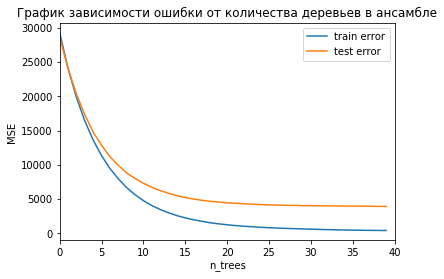

In [40]:
error_tree_plot(n_trees, train_errors, test_errors)

Визуально, после 20 дерева начинается переобучение. Мы видим снижение улучшения ошибки на трейне и на тесте.

In [41]:
n_trees = 30
coefs = [1] * n_trees
max_depth = 10
eta = 0.1
train_errors_arr = []
test_errors_arr = []

for i in list(range(1, max_depth)):
    trees, train_errors, test_errors = gb_fit(n_trees, i, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_err = mean_squared_error(y_train, train_prediction)
    test_err = mean_squared_error(y_test, test_prediction)
    train_errors_arr.append(train_err)
    test_errors_arr.append(test_err)

In [42]:
def depth_error_plot(max_depth, train_err, test_err):
    plt.xlabel('tree_depth')
    plt.ylabel('MSE')
    plt.xlim(0, max_depth)
    plt.plot(list(range(1, max_depth)), train_err, label='train error')
    plt.plot(list(range(1, max_depth)), test_err, label='test error')
    plt.title('Зависимость ошибки от максимальной глубины деревьев')
    plt.legend(loc='upper right')
    plt.show()

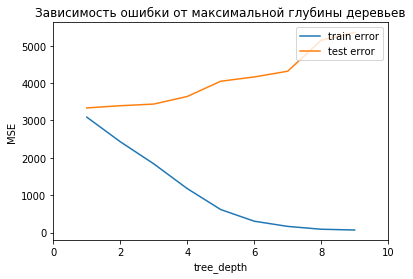

In [43]:
depth_error_plot(max_depth, train_errors_arr, test_errors_arr)

Ошибка на тестовой выборке начинает расти после 3х, на тренировочной ошибка падает на всем интервале. Видим явное переобучение с увеличением глубины деревьев.

### 2*. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. 
###    Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

In [16]:
def sgb_fit(subsample_value, n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    trees = []
    
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
                        
        # генерируем случайную подвыборку
        qtt = int(X_train.shape[0] * subsample_value)
        train_ind = np.random.randint(X_train.shape[0], size=qtt)
    
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train[train_ind], y_train[train_ind])
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train[train_ind], bias(y_train[train_ind], target[train_ind]))
            
            train_errors.append(
                mean_squared_error(
                    y_train, gb_predict(X_train, trees, coefs, eta)
                )
            )
            test_errors.append(
                mean_squared_error(
                    y_test, gb_predict(X_test, trees, coefs, eta)
                )
            )

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [44]:
n_trees = 30
coefs = [1] * n_trees
max_depth = 5
eta = 0.1

In [45]:
%%time

trees, train_errors, test_errors = sgb_fit(0.5, n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 33.5 s


In [46]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 30 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 69.5986
Ошибка алгоритма из 30 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 5356.7283


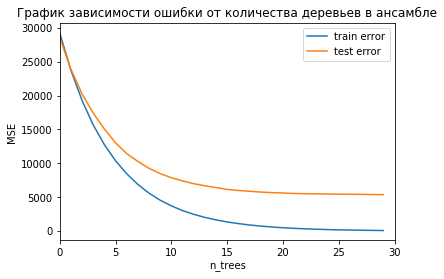

In [47]:
error_tree_plot(n_trees, train_errors, test_errors)